# Traffic Sign Detection


## Introduction to challenge
We have decided to take a dataset from Kaggle ([Traffic Sign Dataset - Classification](https://www.kaggle.com/ahemateja19bec1025/traffic-sign-dataset-classification)) for this challenge.  
The dataset 58 classes and each class has around 120 images. 

## Data Import
Uncomment and adapt path. 

In [1]:
#from google.colab import files
#uploaded = files.upload()
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
## Then move kaggle.json into the folder where the API expects to find it.
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
## Path to file - reminder
##path_to_data = '/content/drive/MyDrive/DeepLearningVisionHSLU/DLV03_Project/data/images/'
### Linux commands for data manipulation
#!kaggle datasets download -d 'ahemateja19bec1025/traffic-sign-dataset-classification'
#!mv ./*.zip /content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/data/
#!unzip -q /content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/data/*.zip -d /content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/data/
#!rm /content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/data/*.zip

## Imports

In [26]:
# Built-in imports
import os
import pathlib
import random
import math
from math import ceil, floor

# Basic imports
import numpy as np
import pandas as pd   

# Ploting libraries
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

import seaborn as sns
sns.set(color_codes=True)

import PIL.Image
import PIL
from PIL import Image
import skimage
from skimage import color, io
#from skimage import data
from skimage import transform

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Train-test-split and evaluation imports
from sklearn.model_selection import train_test_split # If required
from sklearn import metrics # Classification report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

## Definitions

In [3]:
# Show content of dictionary
def get_dir_content(path):
  return os.listdir(path)

# load image
def load_img(path):
  return io.imread(path)

# Show image
def show_image(image, title='Image',cmap_type='gray'):
  plt.imshow(image, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

# Get size of images
def get_shape(img_array):
  return np.shape(img_array)

# Convert img to grayscale
def to_grayscale(img_array):
  grayscale = color.rgb2gray(img_array)
  grayscale *= 255
  return grayscale#.astype(np.uint8)

# Save new image


# Flip image left-right
def flip_lr(img_array):
  return np.fliplr(img_array)

# Flip image up-side-down
def flip_ud(img_array):
  return np.flipud(img_array)

# Warp image 
def warping(img_array):
  tform = transform.SimilarityTransform(
      scale=1, 
      rotation=0,
      translation=(
          np.random.normal(0,img_array.shape[0]/4),
          np.random.normal(0,img_array.shape[1]/4))
      )
  return transform.warp(img_array,tform)

# Rotate image
def rotate(img_array):
  return transform.rotate(img_array, np.random.normal(0,40))


## Data Cleaning and Pre-Processing


### Labels Preparation

In [4]:
# Path to project
path_project_dir = pathlib.Path('/content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/')
# Path to data
path_to_data = path_project_dir.parent / 'traffic_Data' # because of github, this folder has been moved to the parent directory. 

# Get labels
labels = pd.read_csv(
    path_project_dir.joinpath('data','labels.csv'),
    delimiter=",",
    dtype = 'str',
    )

# Check set
print('Labels info:\n')
print(labels.info(),'\n')
print('='*20)
# Check for missing values (no labels)
print('Labels contain "Unkown":\n', labels[labels.Name.str.contains("Unknown")].count(),'\n')
print('='*20)
# Check for missing values
print('Labels Name unique count:\n', labels.Name.count(),'\n')
print('='*20)

Labels info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ClassId  58 non-null     object
 1   Name     58 non-null     object
dtypes: object(2)
memory usage: 1.0+ KB
None 

Labels contain "Unkown":
 ClassId    8
Name       8
dtype: int64 

Labels Name unique count:
 58 



In [5]:
labels

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
5,5,Speed limit (60km/h)
6,6,Speed limit (70km/h)
7,7,speed limit (80km/h)
8,8,Dont Go straight or left
9,9,Dont Go straight or Right


Eight labels are unaccounted for, let's now check which those are. 

In [6]:
unknown_labels = labels[labels.Name.str.contains("Unknown")]
unknown_labels

,ClassId,Name
40,40,Unknown1
41,41,Unknown2
42,42,Unknown3
45,45,Unknown4
49,49,Unknown5
52,52,Unknown6
56,56,Unknown7
57,57,Unknown8


Let's now open for each class a image and manual add the label.

In [7]:
# Convert ids to list
ids_missing_values = labels[labels.Name.str.contains("Unknown")].ClassId.to_list()
# Generate paths 
path_to_missing = [path_to_data.joinpath('DATA',str(id)) for id in ids_missing_values]

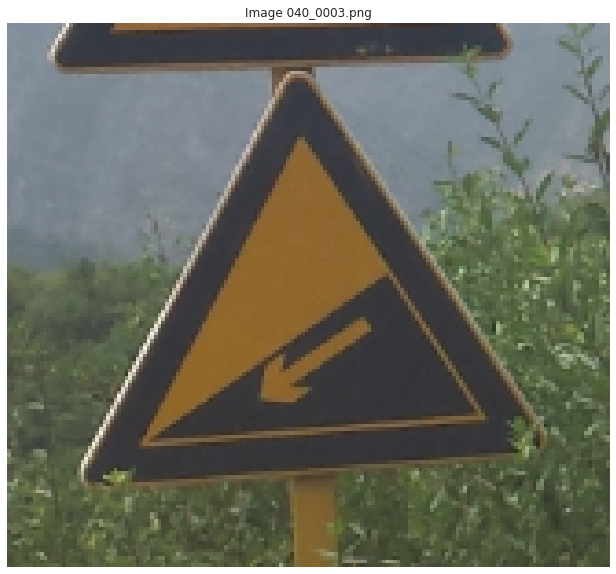

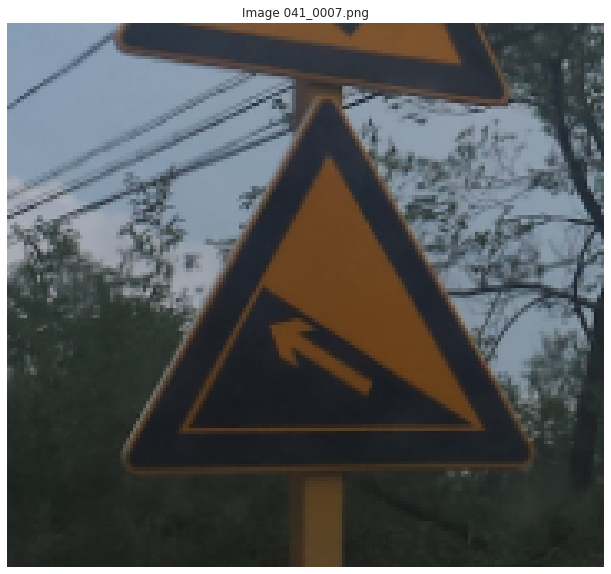

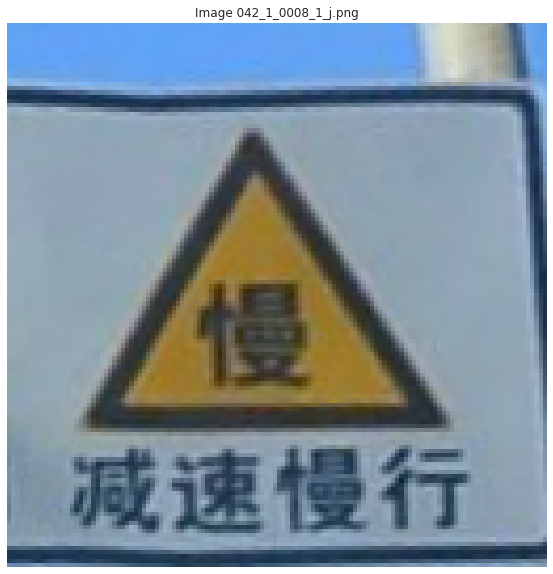

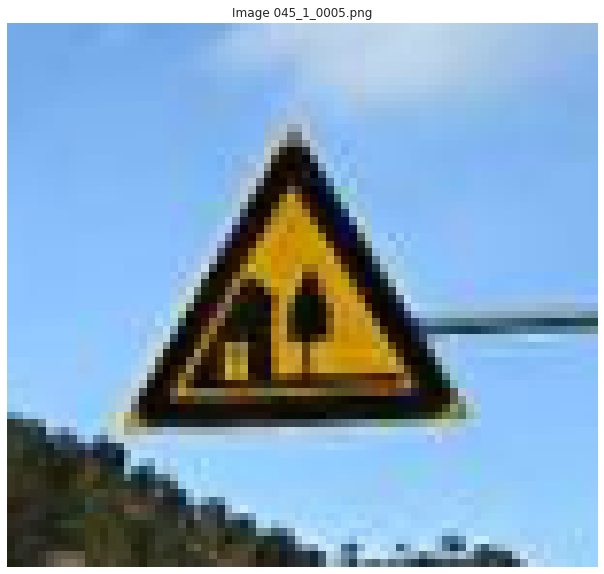

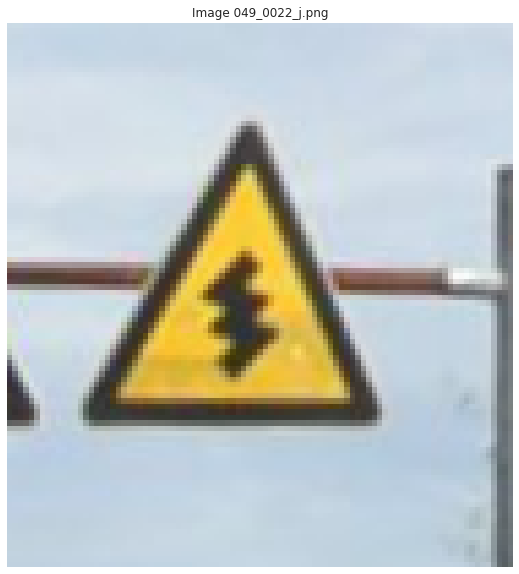

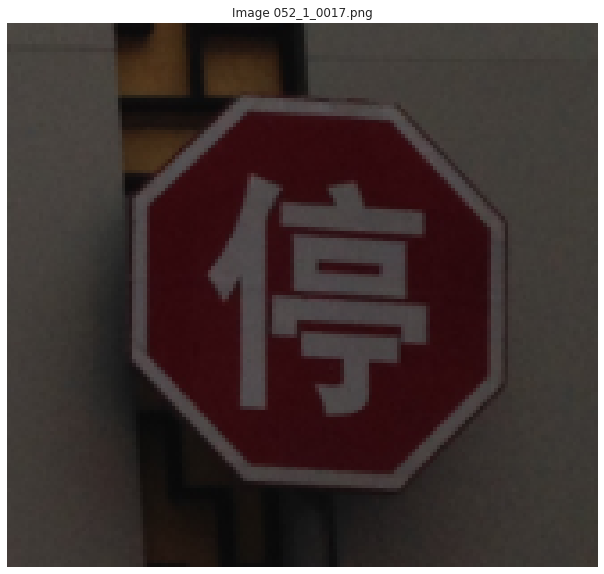

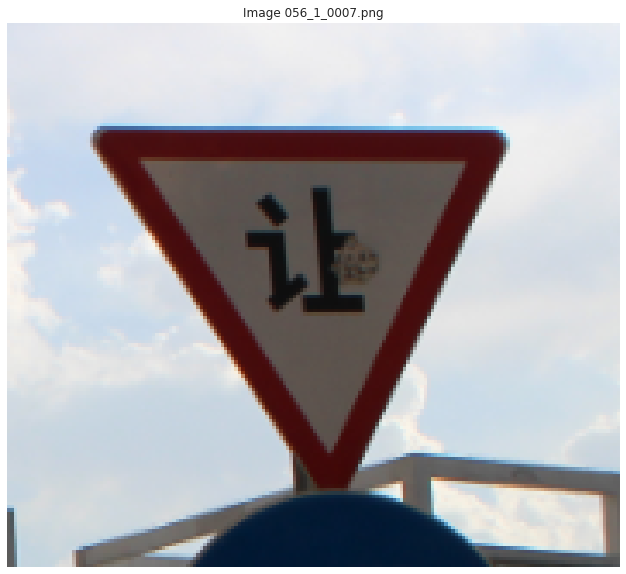

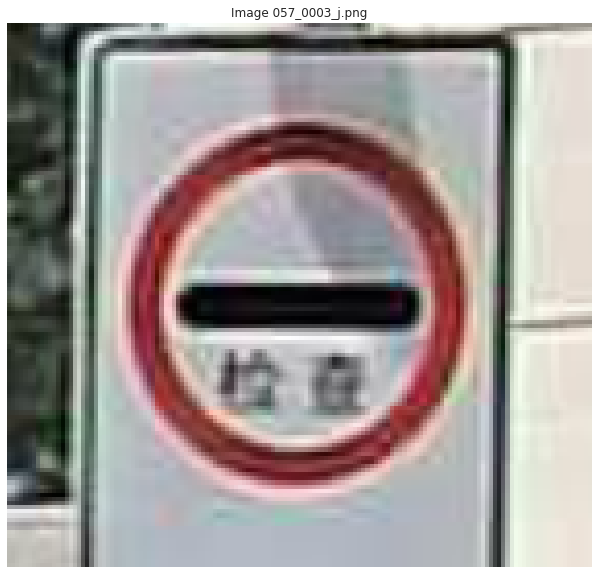

In [8]:
for directory in path_to_missing:
  np_dir_content = np.array(get_dir_content(directory))
  i = random.randint(a = 0, b = np_dir_content.shape[0]-1)
  show_image(
      plt.imread(
          os.path.join(directory, np_dir_content[i])
          ),
      title = f'Image {np_dir_content[i]}',
      )

Categories, 42, 45, 49, 52, 56, 57 seems to be especiall Asian categories and 
Category 40 & 41 are "steep down" and "steep up". 

In [9]:
#labels[labels.ClassId == 40].index.values
labels.at[40,'Name'] = 'Steep down'
labels.at[41,'Name'] = 'Steep up'

### Data Exploration


In [10]:
# Set variable for train path
data_dir = pathlib.Path(path_to_data.joinpath('DATA'))
# Check the number of images for training
image_count = len(list(data_dir.glob('*/*.png')))
print(f'The data set contains {image_count} images. Distributed as follows across the labels:')


The data set contains 4631 images. Distributed as follows across the labels:


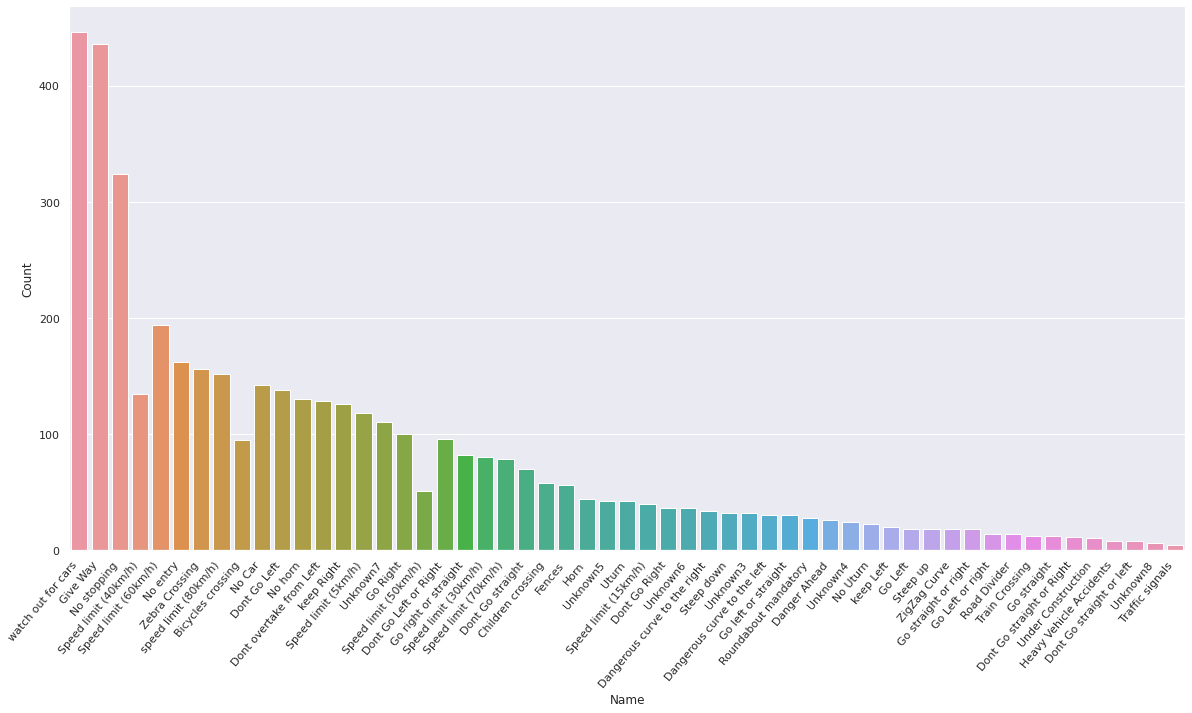

In [11]:
# Subdirectories count
dirs = list(data_dir.glob('*/'))
# Get the number of imgs within a class
no_imgs_class = {str(dir).split('/')[-1]:len(list(dir.glob('*.png'))) for dir in dirs}

# Convert dict to pd dataframe
labels_ = (pd.DataFrame.from_dict(
    {k:[v] for k,v in no_imgs_class.items()}
    )
  .T
  .reset_index()
  .rename(columns={'index':'ClassId',0:'Count'})
  .merge(labels, how = 'left', on = 'ClassId')
  )

# Create Overview plot
chart = sns.barplot(
    x = "Name",
    y = "Count",
    data = labels_.sort_values(by=['Count'], ascending=False),
    ci = None,
    )
chart.set_xticklabels(chart.get_xticklabels(), rotation=50, horizontalalignment='right')
plt.show()

Within the classes the number of images is not so well distributed. 

In [12]:
labels_[(labels_.Count < 50)].sort_values(by = ['Count'])

,ClassId,Count,Name
27,33,4,Traffic signals
11,19,4,Speed limit (50km/h)
53,57,6,Unknown8
47,51,8,Heavy Vehicle Accidents
56,8,8,Dont Go straight or left
10,18,8,Speed limit (40km/h)
43,48,10,Under Construction
57,9,11,Dont Go straight or Right
42,47,12,Train Crossing
14,21,12,Go straight


### Data Augmentation
Since the most traffic signal are sensitive to directions etc. - we are going to try to augment the images only by this:



In [13]:
# Save new image
def save_new_img(img_array, filename, img_path, n):
  io.imsave(str(img_path).replace(filename, filename + f'__c_{n}'), img_array)

# Increase class by oversampling
def oversampling(class_number):
  # Initiate a counter
  n = 1
  # Get the complete path for all imgs within class
  imgs_path = list(path_to_data.joinpath('DATA',f'{class_number}').glob('*.png'))
  # Iterate through images
  for img_path in imgs_path:
    # get name of image
    filename = str(img_path.name)
    # Read-in img
    img_array = io.imread(img_path)
    
    # Warp image
    warped_img = warping(img_array)
    save_new_img(warped_img, filename, img_path, n)
    n += 1

    # Rotate img
    rotated_img = rotate(img_array)
    save_new_img(rotated_img, filename, img_path, n)
    n += 1

    # Check if img is grayscale
    if len(img_array.shape) == 3:
      # Create a grayscale representation
      gray_img_array = to_grayscale(img_array)
      save_new_img(gray_img_array, filename, img_path, n)
      n += 1

      # Wrap graysclae representation
      warped_img = warping(gray_img_array)
      save_new_img(warped_img, filename, img_path, n)
      n += 1

      # Rotate img
      rotated_img = rotate(gray_img_array)
      save_new_img(rotated_img, filename, img_path, n)
      n += 1

  print(f'Class increased by: {n} images.')

# Increase all
#oversampling(33) 

## Definition: Training & Validation sets

### Train Test Split

The Keras method takes the data stored into a folder, with each subfolder corresponding to an individual class. 
In this example, it resizes the images and creates batches automatically. The labels are generated from the subfolder names. The ‘sparse’ format is used to have labels of the form `0,1,2,3,...` because the sparse metrics are used in the model building.
The main advantages of this method are its extreme simplicity and the fact that data augmentation can be done simply by specifying the transformations (rotation, flip, zoom, etc) in the arguments.

In [14]:
image_size = 150
batch_size = 20

# Create training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  #labels = 'inferred',
  #label_mode = 'int',
  validation_split = 0.2,
  subset="training",
  shuffle = True,
  seed = 123,
  image_size = (image_size, image_size), # Reshaped with not in this size
  #batch_size = batch_size,
  )

# Create validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  #labels = 'inferred',
  #label_mode = 'int',
  validation_split = 0.2,
  subset="validation",
  shuffle = True,
  seed = 123,
  image_size = (image_size, image_size), # Reshaped with not in this size
  #batch_size = batch_size,
  )

Found 4631 files belonging to 58 classes.
Using 3705 files for training.
Found 4631 files belonging to 58 classes.
Using 926 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '6', '7', '8', '9']


In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.04088889 0.97217304


## Model

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
num_classes = len(labels.ClassId)

model = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255)])
model.add(tf.keras.layers.Conv2D(
        32, (3, 3), 
        padding='same',
        input_shape = (image_size, image_size, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('softmax'))

model.compile(loss=tf.losses.SparseCategoricalCrossentropy(),#from_logits=True),#'categorical_crossentropy',
              optimizer='adam',
              metrics=[
                       'accuracy',
                       #tf.keras.metrics.Accuracy(),
                       #tf.keras.metrics.Precision(),
                       #tf.keras.metrics.Recall(),
                       #tf.keras.metrics.AUC(),
                       #tf.keras.metrics.MeanSquaredError()
                       ]
              )

In [19]:
name = 'FirstTry'
tensorboard = TensorBoard(
        log_dir='./tensorboard/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [28]:
num_train_images = 3705

history = model.fit(
    train_ds,
    #steps_per_epoch = math.ceil(num_train_images / batch_size),
    validation_data = val_ds,
    epochs = 20,
    callbacks = [tensorboard],
)

Epoch 1/20
116/116 [==============================] - 5s 43ms/step - loss: 0.0436 - accuracy: 0.9997 - val_loss: 0.0338 - val_accuracy: 0.9946
Epoch 2/20
116/116 [==============================] - 5s 43ms/step - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0.0340 - val_accuracy: 0.9946
Epoch 3/20
116/116 [==============================] - 5s 42ms/step - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.0332 - val_accuracy: 0.9924
Epoch 4/20
116/116 [==============================] - 5s 42ms/step - loss: 0.0361 - accuracy: 1.0000 - val_loss: 0.0303 - val_accuracy: 0.9968
Epoch 5/20
116/116 [==============================] - 5s 45ms/step - loss: 0.0337 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 0.9924
Epoch 6/20
116/116 [==============================] - 5s 42ms/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 0.9924
Epoch 7/20
116/116 [==============================] - 5s 42ms/step - loss: 0.0305 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 0.9924

## Evaluation and Post-Processing

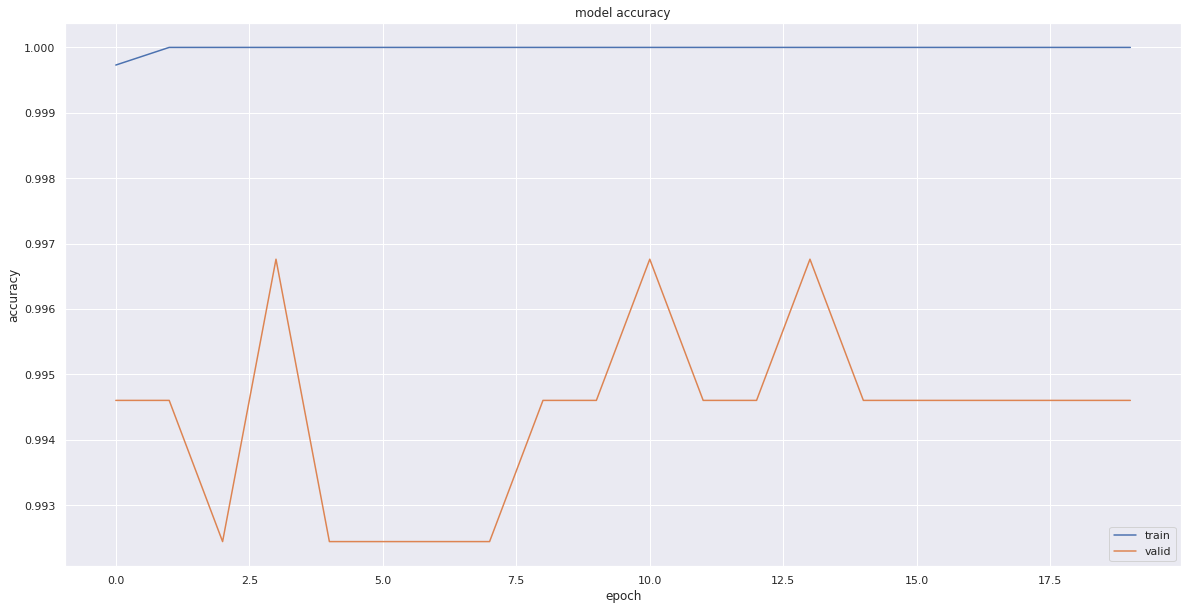

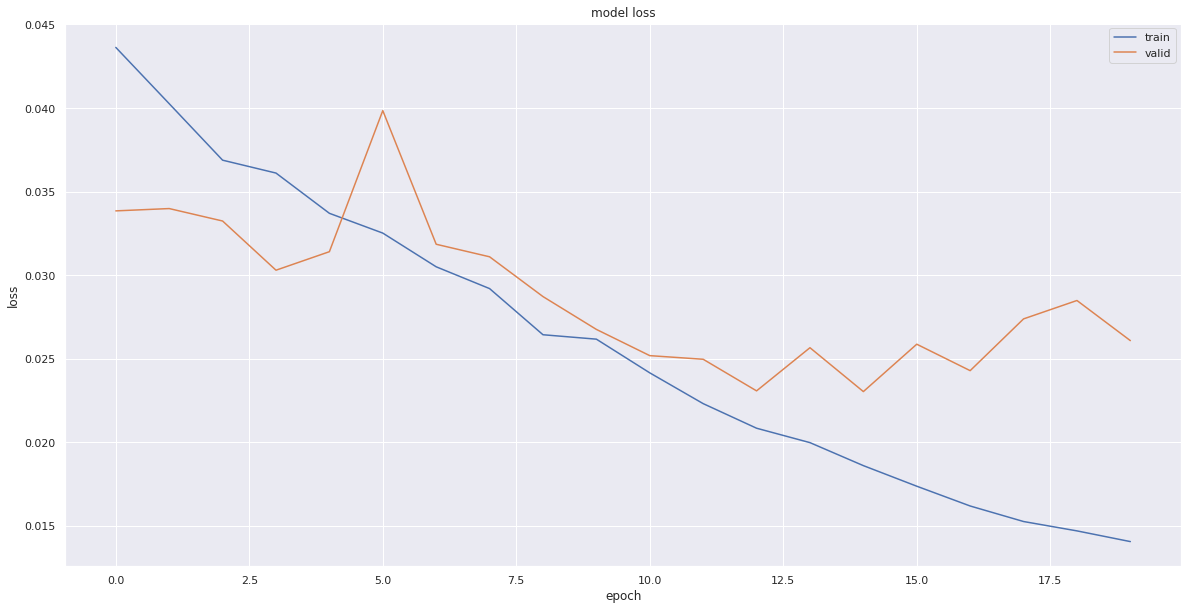

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# Final Words 

In [ ]:
## This is the augmentation configuration we will use for training
#train_datagen = ImageDataGenerator(
#        rescale=1./255,
#        shear_range=0.2,
#        zoom_range=0.2,
#        horizontal_flip=False)
#
## This is the augmentation configuration we will use for validation:
## only rescaling
#validation_datagen = ImageDataGenerator(
#        rescale=1./255)
#
## This is a generator that will read pictures found in
## subfolers of './train', and indefinitely generate
## batches of augmented image data
#train_generator = train_datagen.flow_from_directory(
#        './train',  # this is the target directory
#        target_size=(image_size, image_size),  # all images will be resized to 150x150
#        classes = labels.ClassId,
#        batch_size = batch_size)  
#
## This is a similar generator, for validation data
#validation_generator = validation_datagen.flow_from_directory(
#        './validation',
#        target_size = (image_size, image_size),
#        classes = labels.ClassId,
#        batch_size = batch_size)